In [1]:
import numpy as np
import tensorflow as tf

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform
from lucid.misc.channel_reducer import ChannelReducer
import sys

from lucid.misc.io import show, load

In [2]:
model = models.InceptionResnet2()
model.load_graphdef()

In [3]:
for node in model.graph_def.node:
  if 'Concat' in node.op:
    print(node.name)

InceptionResnetV2/Mixed_5b/concat
InceptionResnetV2/Repeat/block35_1/concat
InceptionResnetV2/Repeat/block35_2/concat
InceptionResnetV2/Repeat/block35_3/concat
InceptionResnetV2/Repeat/block35_4/concat
InceptionResnetV2/Repeat/block35_5/concat
InceptionResnetV2/Repeat/block35_6/concat
InceptionResnetV2/Repeat/block35_7/concat
InceptionResnetV2/Repeat/block35_8/concat
InceptionResnetV2/Repeat/block35_9/concat
InceptionResnetV2/Repeat/block35_10/concat
InceptionResnetV2/Mixed_6a/concat
InceptionResnetV2/Repeat_1/block17_1/concat
InceptionResnetV2/Repeat_1/block17_2/concat
InceptionResnetV2/Repeat_1/block17_3/concat
InceptionResnetV2/Repeat_1/block17_4/concat
InceptionResnetV2/Repeat_1/block17_5/concat
InceptionResnetV2/Repeat_1/block17_6/concat
InceptionResnetV2/Repeat_1/block17_7/concat
InceptionResnetV2/Repeat_1/block17_8/concat
InceptionResnetV2/Repeat_1/block17_9/concat
InceptionResnetV2/Repeat_1/block17_10/concat
InceptionResnetV2/Repeat_1/block17_11/concat
InceptionResnetV2/Repeat_

In [5]:
def render_activation_grid_less_naive(img, model, layer="InceptionResnetV2/Mixed_5b/concat", W=42,
                                 n_groups=6, subsample_factor=1, n_steps=256):
  
  # Get the activations
  with tf.Graph().as_default(), tf.Session() as sess:
    t_input = tf.placeholder("float32", [None, None, None, 3])
    T = render.import_model(model, t_input, t_input)
    acts = T(layer).eval({t_input: img[None]})[0]
  acts_flat = acts.reshape([-1] + [acts.shape[2]])
  N = acts_flat.shape[0]
  print('1')
  
  # The trick to avoiding "decoherence" is to recognize images that are
  # for similar activation vectors and 
  if n_groups > 0:
    reducer = ChannelReducer(n_groups, "NMF")
    groups = reducer.fit_transform(acts_flat)
    groups /= groups.max(0)
  else:
    groups = np.zeros([])
    
  print groups.shape
  print('2')

  
  # The key trick to increasing memory efficiency is random sampling.
  # Even though we're visualizing lots of images, we only run a small
  # subset through the network at once. In order to do this, we'll need
  # to hold tensors in a tensorflow graph around the visualization process.
  
  with tf.Graph().as_default() as graph, tf.Session() as sess:
    
    
    # Using the groups, create a paramaterization of images that
    # partly shares paramters between the images for similar activation
    # vectors. Each one still has a full set of unique parameters, and could
    # optimize to any image. We're just making it easier to find solutions
    # where things are the same.
    group_imgs_raw = param.fft_image([n_groups, W, W, 3])
    print '2_1'
    unique_imgs_raw = param.fft_image([N, W, W, 3])
    print '2_2'
    opt_imgs = param.to_valid_rgb(tf.stack([
            0.7*unique_imgs_raw[i] + 
            0.5*sum(groups[i, j] * group_imgs_raw[j] for j in range(n_groups))
            for i in range(N) ]),
            decorrelate=True)
    print('3')
    
    # Construct a random batch to optimize this step
    batch_size = 32
    rand_inds = tf.random_uniform([batch_size], 0, N, dtype=tf.int32)
    print '3_1'
    pres_imgs = tf.gather(opt_imgs, rand_inds)
    print '3_2'
    print pres_imgs.shape
    pres_acts = tf.gather(acts_flat, rand_inds)
    print '3_3'
    obj = objectives.Objective.sum(
      [objectives.direction(layer, pres_acts[n], batch=n)
       for n in range(batch_size)
      ])
    print('4')
    
    # Actually do the optimization...
    T = render.make_vis_T(model, obj, param_f=pres_imgs)
    tf.global_variables_initializer().run()
    print('5')
    
    for i in range(n_steps):
      T("vis_op").run()
      print i
      if (i+1) % (n_steps//2) == 0:
        show(pres_imgs.eval()[::4])
      if i % 10 == 0:
        print 'Step: ', i
    print('6')
    
    vis_imgs = opt_imgs.eval()
    
  # Combine the images and display the resulting grid
  print ""
  vis_imgs_ = vis_imgs.reshape(list(acts.shape[:2]) + [W, W, 3])
  vis_imgs_cropped = vis_imgs_[:, :, 2:-2, 2:-2, :]
  show(np.hstack(np.hstack(vis_imgs_cropped)))
  return vis_imgs_cropped

In [ ]:
img = load("/home/elebouder/Data/ChestXray-NIHCC/test.png")
_ = render_activation_grid_less_naive(img, model, W=48, n_steps=256)

1
(1225, 6)
2
2_1
2_2
3
3_1
3_2
(32, 48, 48, 3)
3_3
4
5
0
Step:  0
1
2
3
4
5
6
7
8
9
10
Step:  10
11
12
13
14
15
16
17
18
19
20
Step:  20
21
22
23
24
25
26
27
28
29
30
Step:  30
31
32


(299, 299, 3)



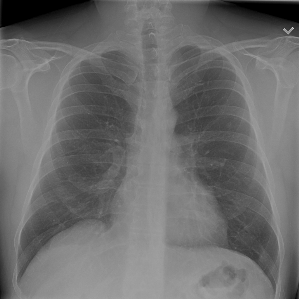

In [5]:
img = load("/home/elebouder/Data/ChestXray-NIHCC/test.png")
print img.shape
show(img)